# Handle geographical files

In this example, we will work with raster and shapefile formats.

In [1]:
from glob import glob
from math import floor, log10, ceil
from matplotlib import pyplot as plt
from pprint import pprint
from rasterio.features import rasterize
from rasterio.transform import from_origin, IDENTITY

import fiona
import geopandas as gpd
import gdal
import geopy.distance
import numpy as np
import rasterio

Some extra functions

In [2]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

## Import from GeoJSON to Shapefile

In [3]:
# geojson_files = glob('../AlertaDengue/static/geojson/*')

# vitoria/es
# geojson_files = ['../AlertaDengue/static/geojson/3205309.json']

# curitiba/pr
geojson_files = ['../AlertaDengue/static/geojson/4106902.json']

In [4]:
# convert from geojson to shapefile
with fiona.open(geojson_files[0]) as geojson_file:
    with fiona.open(
        "/tmp/test.shp", "w",
        crs=geojson_file.crs, 
        driver="ESRI Shapefile", 
        schema=geojson_file.schema.copy()
    ) as shp:
        for item in geojson_file:
            shp.write(item)

## Open Shapefile

In [5]:
#shp = fiona.open('zonas_farrapos.shp')
shp = fiona.open('/tmp/test.shp', 'r', enabled_drivers=['ESRI Shapefile'])

In [6]:
def show_attrs(shp: "fiona shapefile"):
    """
    """
    shp_struct = [
        (v, 'method'if callable(getattr(shp, v, None)) else 
         'attribute'
        ) 
        for v in dir(shp) 
        if not v.startswith('_')
    ]

    return [
        (shp_attr, getattr(shp, shp_attr))
        for shp_attr, shp_type in shp_struct
        if shp_type == 'attribute'
    ]

In [7]:
show_attrs(shp)

[('bounds',
  (-49.38933863648889, -25.645386219768298, -49.185225, -25.3467360301656)),
 ('closed', False),
 ('crs', {'init': 'epsg:4326'}),
 ('crs_wkt',
  'GEOGCS["GCS_WGS_1984",DATUM["WGS_1984",SPHEROID["WGS_84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295],AUTHORITY["EPSG","4326"]]'),
 ('driver', 'ESRI Shapefile'),
 ('enabled_drivers', ['ESRI Shapefile']),
 ('encoding', 'utf-8'),
 ('env', <fiona._drivers.GDALEnv at 0x7f39a8bb2bb8>),
 ('iterator', None),
 ('meta',
  {'crs': {'init': 'epsg:4326'},
   'crs_wkt': 'GEOGCS["GCS_WGS_1984",DATUM["WGS_1984",SPHEROID["WGS_84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295],AUTHORITY["EPSG","4326"]]',
   'driver': 'ESRI Shapefile',
   'schema': {'geometry': 'Polygon',
    'properties': OrderedDict([('geocodigo', 'int:9'),
                 ('nome', 'str:80'),
                 ('populacao', 'int:9')])}}),
 ('mode', 'r'),
 ('name', 'test'),
 ('path', '/tmp/test.shp'),
 ('profi

In [8]:
print(
    'keys: %s' % shp[0].keys(), 
    'type: %s' % shp[0]['type'],
    'id: %s' % shp[0]['id'],
    'properties: %s' % shp[0]['properties'],
    'geometry.keys: %s' % shp[0]['geometry'].keys(), 
    sep='\n'
)

keys: dict_keys(['type', 'id', 'geometry', 'properties'])
type: Feature
id: 0
properties: OrderedDict([('geocodigo', 4106902), ('nome', 'Curitiba'), ('populacao', 1893997)])
geometry.keys: dict_keys(['type', 'coordinates'])


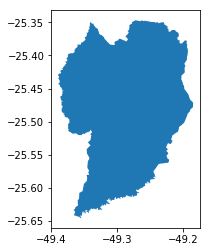

In [9]:
gdf = gpd.GeoDataFrame.from_file('/tmp/test.shp')
gdf.plot()
plt.show()

## Calculate the boundaries

In [10]:
shp.bounds

(-49.38933863648889, -25.645386219768298, -49.185225, -25.3467360301656)

In [11]:
coords_1 = shp.bounds[1], shp.bounds[0]
coords_2 = shp.bounds[3], shp.bounds[0]

height = geopy.distance.vincenty(coords_1, coords_2).km

coords_2 = shp.bounds[1], shp.bounds[2]

width = geopy.distance.vincenty(coords_1, coords_2).km

print('-'*80)
print('width (km):\t', width)
print('height (km):\t', height)

--------------------------------------------------------------------------------
width (km):	 20.4963511819909
height (km):	 33.084565847798615


In [12]:
# res = 0.000901
res_x = (shp.bounds[2] - shp.bounds[0]) / width
res_y = (shp.bounds[3] - shp.bounds[1]) / height

print(res_x, res_y)

out_shape = int(height), int(width)

print('shape:\t', out_shape)
print('-'*80)
print('res_x:\t', res_x)
print('res_y:\t', res_y)

0.009958535286428373 0.009026873466516053
shape:	 (33, 20)
--------------------------------------------------------------------------------
res_x:	 0.009958535286428373
res_y:	 0.009026873466516053


In [13]:
transform = from_origin(
    shp.bounds[0] - res_x / 2,
    shp.bounds[3] + res_y / 2, 
    res_x, res_y
)
transform

Affine(0.009958535286428373, 0.0, -49.3943179041321,
       0.0, -0.009026873466516053, -25.342222593432343)

## Rasterize

In [14]:
# https://mapbox.github.io/rasterio/topics/masking-by-shapefile.html
rgb_values = hex_to_rgb('#ff9900')
rgb_values

(255, 153, 0)

In [15]:
features = [
    [(feature['geometry'], color)]
    for feature in shp
    for color in rgb_values
]
print(
    len(features), 
    features[0][0][0].keys(),
    features[0][0][0]['type']
)

3 dict_keys(['type', 'coordinates']) Polygon


In [16]:
# shapes = [(geometry['geometry'], k) for k, geometry in shp.items()]

In [17]:
dtype = rasterio.float64
nodata = np.nan

raster_args = dict(
    out_shape=out_shape,
    fill=nodata,
    transform=transform,
    dtype=dtype,
    all_touched=True
)

rasters = [rasterize(feature, **raster_args) for feature in features]

### Save to GeoTIFF

In [18]:
f_tiff_path = '/tmp/test.tiff'

with rasterio.drivers():
    with rasterio.open(
        f_tiff_path, 
        mode='w',
        crs=shp.crs,
        driver='GTiff',
        # profile='GeoTIFF',
        dtype=dtype,
        count=len(rgb_values),
        width=width,
        height=height,
        nodata=nodata,
        transform=transform,
        photometric='RGB'
    ) as dst:
        # help(dst.write)
        for i in range(1, 4):
            # print(i, rasters[i-1].shape)
            dst.write_band(i, rasters[i-1])
            dst.write_colormap(
                i, {0: (255, 0, 0),
                    255: (0, 0, 255) })
        # cmap = dst.colormap(1)
        # assert cmap[0] == (255, 0, 0, 255)
        # assert cmap[255] == (0, 0, 255, 255)

In [19]:
ds = gdal.Open(f_tiff_path, gdal.GA_Update)
for i in range(ds.RasterCount):
    ds.GetRasterBand(i + 1).ComputeStatistics(True)
    print('='*80)
    print(ds.GetRasterBand(i + 1).ComputeStatistics(True))
    
ds = band = None  # save, close

[255.0, 255.0, 255.0, 0.0]
[153.0, 153.0, 153.0, 0.0]
[0.0, 0.0, 0.0, 0.0]


## Open GeoTIFF files

In [20]:
src = rasterio.open('/tmp/test.tiff')

r, g, b = src.read()
print('width, heigh:', src.width, src.height)
print('crs:', src.crs)
print('transform:', src.transform)
print('count:', src.count)
print('indexes:', src.indexes)
print('colorinterp (1):', src.colorinterp(1))
print('colorinterp (2):', src.colorinterp(2))
print('colorinterp (3):', src.colorinterp(3))
# print(help(src))
print('nodatavals:', src.nodatavals)
print('nodata:', src.nodata)
print('mask (dtype):', src.read_masks().dtype)

bands = (
    ('r', r),
    ('g', g),
    ('b', b)
)

for k, band in bands:
    print('\n', k, ':')
    print('min: %s (%s)' % (np.nanmin(band), np.min(band)))
    print('max: %s (%s)' % (np.nanmax(band), np.max(band)))

width, heigh: 20 33
crs: CRS({'init': 'epsg:4326'})
transform: [-49.3943179041321, 0.009958535286428373, 0.0, -25.342222593432343, 0.0, -0.009026873466516053]
count: 3
indexes: (1, 2, 3)
colorinterp (1): ColorInterp.grey
colorinterp (2): ColorInterp.grey
colorinterp (3): ColorInterp.grey
nodatavals: (nan, nan, nan)
nodata: nan
mask (dtype): uint8

 r :
min: 255.0 (nan)
max: 255.0 (nan)

 g :
min: 153.0 (nan)
max: 153.0 (nan)

 b :
min: 0.0 (nan)
max: 0.0 (nan)


/home/xmn/miniconda3/envs/alertadengue/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


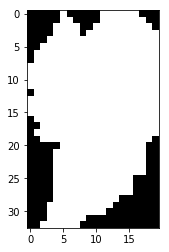

In [21]:
plt.imshow(np.dstack(src.read_masks()))
plt.show()
src.close()

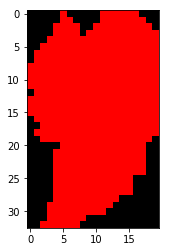

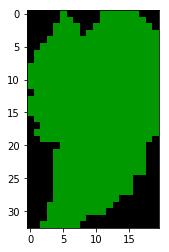

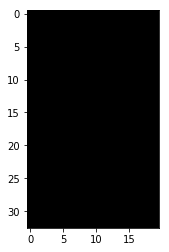

In [22]:
total = np.zeros(r.shape)
for i, band in enumerate([r, g, b]):
    
    img_rgb = np.zeros((r.shape + (3,)), 'float64')

    img_rgb[..., i] = band/255
    
    plt.imshow(img_rgb, cmap="gnuplot", vmin=0., vmax=1.)
    plt.show()

(33, 20, 3)


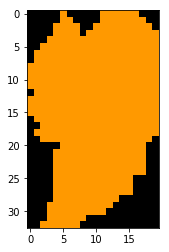

In [23]:
img_rgb = np.zeros((r.shape + (3,)), 'float64')

img_rgb[..., 0] = r/255
img_rgb[..., 1] = g/255
img_rgb[..., 2] = b/255

print(img_rgb.shape)

plt.imshow(img_rgb, cmap='gnuplot', vmin=0., vmax=1.)
plt.show()

In [24]:
import pandas as pd
for i in range(3):
    display(pd.DataFrame(img_rgb[:,:,i]))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN
2,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
3,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,NaN,NaN,NaN,NaN,NaN,0.6,NaN,NaN,NaN,NaN,NaN,0.6,0.6,0.6,0.6,0.6,0.6,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,0.6,0.6,NaN,NaN,NaN,NaN,0.6,0.6,0.6,0.6,0.6,0.6,0.6,NaN,NaN
2,NaN,NaN,NaN,NaN,0.6,0.6,0.6,0.6,NaN,NaN,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,NaN
3,NaN,NaN,NaN,NaN,0.6,0.6,0.6,0.6,NaN,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6
4,NaN,NaN,NaN,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6
5,NaN,NaN,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6
6,NaN,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6
7,NaN,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6
8,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6
9,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Refs

http://nbviewer.jupyter.org/gist/ocefpaf/53e5be14d58c1b946952a7293f2005cf

https://github.com/mapbox/rasterio/blob/6b02fd304d10995cff818729abe47f28bd7a33b5/examples/rasterize_geometry.py

https://mapbox.github.io/rasterio/topics/masking-by-shapefile.html

http://docs.qgis.org/2.0/es/docs/gentle_gis_introduction/raster_data.html